# Notebook 2: Building a Custom Component - Slab Ocean

## Learning Goals

- Understand the component interface contract
- Build a SlabOcean from scratch
- Couple the custom SlabOcean with sea ice and a prognostic atmosphere

---

## Why Build Custom Components?

Sometimes you don't need the full complexity of a 3D ocean. **Slab models** are simplified single-layer representations that are computationally cheap, capture essential thermodynamics, and provide excellent learning opportunities.

In this notebook, we'll build a `SlabOcean` from scratch, then couple it with sea ice and SpeedyWeather to create a full Earth system model!

In [1]:
using Pkg
Pkg.activate("./")

using ClimaOcean
using Oceananigans
using Oceananigans.Units
using ClimaOcean.OceanSeaIceModels
using ClimaOcean.OceanSeaIceModels.InterfaceComputations
using ClimaOcean.Oceans
using CairoMakie
using Printf
using Dates
using Oceananigans.TimeSteppers

  Activating project at `~/development/workshop`


## Part 1: A Slab Ocean implementation

A slab ocean implementation consists of:

1. **The struct**: Holds grid, clock, temperature, and flux fields
2. **Interface methods**: Tell the coupling system how to interact with this component
3. **Time stepping**: Temperature evolves based on net heat flux into/out of the slab

In [2]:
struct SlabOcean{G, C, T, F}
    grid :: G
    clock :: C
    temperature :: T
    temperature_flux :: F
end

function SlabOcean(grid; clock=Oceananigans.Clock(time=0))
    temperature = CenterField(grid)
    temperature_flux = CenterField(grid)
    return SlabOcean(grid, clock, temperature, temperature_flux)
end

Base.summary(o::SlabOcean) = "SlabOcean(depth=$(o.grid.Lz)m)"
Base.show(io::IO, o::SlabOcean) = print(io, summary(o))

### Interface Methods for Slab Ocean

These methods tell the coupling framework how to interact with our custom component:

| Method | Purpose |
|--------|---------|
| `ComponentExchanger` | Returns state variables (T, S, u, v) that atmosphere/sea ice need |
| `net_fluxes` | Returns fields where computed fluxes are stored |
| `reference_density`, `heat_capacity` | Physical properties for flux calculations |
| `ocean_temperature`, `ocean_salinity` | Accessors for ocean state fields |
| `update_net_fluxes!` | Computes net flux each time step |

The coupling framework calls these methods automatically during simulation setup and time stepping.

In [3]:
using Oceananigans.Grids: AbstractGrid

# ComponentExchanger: What state variables does this component expose?
function InterfaceComputations.ComponentExchanger(ocean::SlabOcean, exchange_grid)
    T = ocean.temperature
    S = OceanSeaIceModels.ocean_surface_salinity(ocean)
    u, v = OceanSeaIceModels.ocean_surface_velocities(ocean)
    return InterfaceComputations.ComponentExchanger((; u, v, T, S), nothing)
end

# net_fluxes: Where should computed fluxes be stored?
function InterfaceComputations.net_fluxes(ocean::SlabOcean)
    grid = ocean.grid
    Jˢ = Oceananigans.Field{Center, Center, Nothing}(grid)  # Salt flux (unused)
    τx = Oceananigans.Field{Center, Center, Nothing}(grid)  # x-momentum (unused)
    τy = Oceananigans.Field{Center, Center, Nothing}(grid)  # y-momentum (unused)
    return (T=ocean.temperature_flux, S=Jˢ, u=τx, v=τy)
end

InterfaceComputations.default_exchange_grid(atmos, ocean::SlabOcean, sea_ice) = ocean.grid

# Physical properties
OceanSeaIceModels.reference_density(::SlabOcean) = 1025.f0  # kg/m³
OceanSeaIceModels.heat_capacity(::SlabOcean) = 3990.f0      # J/(kg·K)

# State accessors
OceanSeaIceModels.ocean_surface_salinity(::SlabOcean) = Oceananigans.Fields.ConstantField(35.0)
OceanSeaIceModels.ocean_salinity(::SlabOcean) = Oceananigans.Fields.ConstantField(35.0)
OceanSeaIceModels.ocean_temperature(ocean::SlabOcean) = ocean.temperature

# Net flux computation
OceanSeaIceModels.update_net_fluxes!(coupled_model, ocean::SlabOcean) =
    Oceans.update_net_ocean_fluxes!(coupled_model, ocean, ocean.grid)

### Time Stepping for Slab Ocean

The physics is simple: temperature changes based on net heat flux.

$$\frac{\partial T}{\partial t} = -\frac{Q}{h \cdot \rho \cdot c_p}$$

where $h$ is slab depth, $\rho$ is density, $c_p$ is heat capacity, and $Q$ is net heat flux.

Positive flux means ocean loses heat (cooling); negative flux means ocean gains heat (warming). Deeper slabs respond more slowly to the same heat flux. The flux is already divided by $\rho \cdot c_p$ in the coupling framework, so we just divide by depth.

In [4]:
# Time stepping: evolve temperature based on flux
function TimeSteppers.time_step!(ocean::SlabOcean, Δt)
    TimeSteppers.tick!(ocean.clock, Δt)
    # temperature_flux is in units of ᵒC·m/s (already divided by ρ·cₚ)
    # So: dT/dt = -flux / depth
    parent(ocean.temperature) .-= parent(ocean.temperature_flux) .* Δt ./ ocean.grid.Lz
    Oceananigans.ImmersedBoundaries.mask_immersed_field!(ocean.temperature)
    return nothing
end

---

## Part 2: Couple SlabOcean with Sea Ice and SpeedyWeather

Now let's couple our custom SlabOcean with sea ice and a SpeedyWeather prognostic atmosphere, demonstrating that custom components integrate seamlessly with the coupling framework.

In [ ]:
# Create a 2D grid for the slab ocean (single vertical level)
slab_grid = TripolarGrid(Oceananigans.CPU(), Float32; size=(180, 90, 1), z=(-50, 0), halo=(5, 5, 4))

bottom_height = regrid_bathymetry(slab_grid; minimum_depth=15, major_basins=1, interpolation_passes=5)
slab_grid = ImmersedBoundaryGrid(slab_grid, GridFittedBottom(bottom_height); active_cells_map=true)

@info "Created 2D slab grid: $(slab_grid.Nx)×$(slab_grid.Ny) with depth $(slab_grid.Lz)"

LoadError: InterruptException:

### Create Our Custom SlabOcean and Initialize

We initialize the SlabOcean from **ECCO4 Monthly climatology** using `ECCOMetadatum(:temperature)`, which loads and interpolates observed sea surface temperature onto our grid.

In [ ]:
ENV["ECCO_USERNAME"] = "xxxxx"
ENV["ECCO_WEBDAV_PASSWORD"] = "xxxx"

# Create our custom SlabOcean
slab_ocean = SlabOcean(slab_grid)

# Initialize temperature from ECCO climatology
Oceananigans.set!(slab_ocean.temperature, ECCOMetadatum(:temperature))
Oceananigans.ImmersedBoundaries.mask_immersed_field!(slab_ocean.temperature)

@info "SlabOcean created and initialized!"
@info "Temperature range: $(extrema(slab_ocean.temperature))"

[ Info: SlabOcean created and initialized!
[ Info: Temperature range: (-1.968946f0, 31.01314f0)


### Add Sea Ice and SpeedyWeather Atmosphere

We add sea ice using `sea_ice_simulation` with `dynamics=nothing` (thermodynamics only), and create a SpeedyWeather atmosphere with T31 spectral resolution (~400km) and 8 vertical levels.

In [17]:
using SpeedyWeather, XESMF

# Create sea ice simulation (using ClimaOcean's built-in)
sea_ice = sea_ice_simulation(slab_grid, slab_ocean, dynamics=nothing)

Oceananigans.set!(sea_ice.model, h=ECCOMetadatum(:sea_ice_thickness),
                                 ℵ=ECCOMetadatum(:sea_ice_concentration))

# Create SpeedyWeather prognostic atmosphere
spectral_grid = SpeedyWeather.SpectralGrid(; trunc=31, nlayers=8, Grid=FullClenshawGrid)
atmos = atmosphere_simulation(spectral_grid; output=true)

@info "Sea ice and atmosphere ready!"

[ Info: Sea ice and atmosphere ready!


### Visualize Initial Conditions

Initial state of our three-component system: SlabOcean SST, sea ice thickness, and sea ice concentration. SST is near freezing where ice is present, confirming physically consistent initialization.

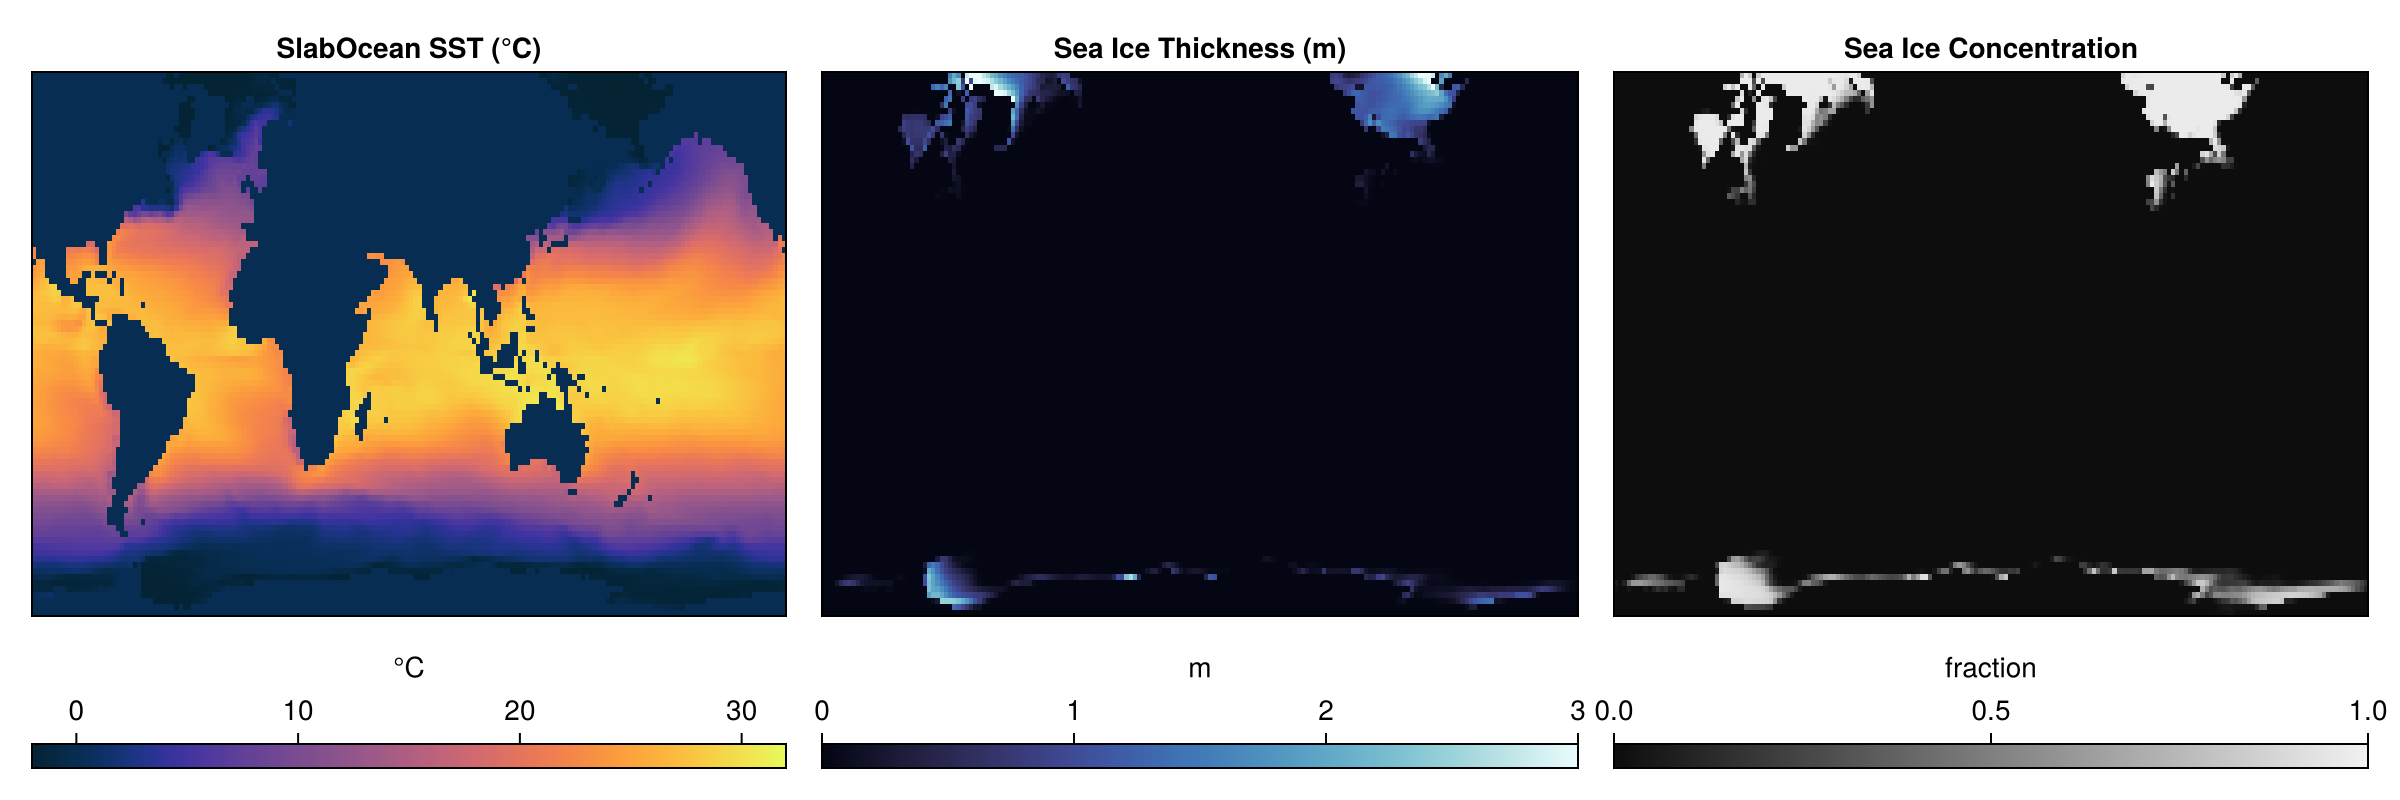

In [18]:
# Extract initial fields
SST_init = Array(interior(slab_ocean.temperature, :, :, 1))
h_init   = Array(interior(sea_ice.model.ice_thickness, :, :, 1))
ℵ_init   = Array(interior(sea_ice.model.ice_concentration, :, :, 1))

fig = Figure(size=(1200, 400), fontsize=14)

ax1 = Axis(fig[1, 1], title="SlabOcean SST (°C)")
ax2 = Axis(fig[1, 2], title="Sea Ice Thickness (m)")
ax3 = Axis(fig[1, 3], title="Sea Ice Concentration")

hm1 = heatmap!(ax1, SST_init; colormap=:thermal, colorrange=(-2, 32), nan_color=:lightgray)
hm2 = heatmap!(ax2, h_init;   colormap=:ice,     colorrange=(0, 3), nan_color=:lightgray)
hm3 = heatmap!(ax3, ℵ_init;   colormap=:grays,   colorrange=(0, 1), nan_color=:lightgray)

Colorbar(fig[2, 1], hm1, label="°C", vertical=false)
Colorbar(fig[2, 2], hm2, label="m", vertical=false)
Colorbar(fig[2, 3], hm3, label="fraction", vertical=false)

for ax in [ax1, ax2, ax3]
    hidedecorations!(ax)
end

fig

### Couple, Set Up Output Writer, and Run the Simulation

We run for **30 days**—slab models are fast since there's no complex 3D numerics, just simple temperature evolution. The 50m depth responds quickly to surface fluxes.

In [21]:
# Couple our custom SlabOcean with sea ice and SpeedyWeather!
coupled_model = OceanSeaIceModel(slab_ocean, sea_ice; atmosphere=atmos)

@info "Coupled SlabOcean + SeaIce + SpeedyWeather model created!"

[ Info: Coupled SlabOcean + SeaIce + SpeedyWeather model created!


In [ ]:
# Run for 30 days (slab models are fast!)
Δt = atmos.model.time_stepping.Δt_sec
simulation = Oceananigans.Simulation(coupled_model; Δt, stop_time=30days)

# Set up output writer for slab ocean temperature and sea ice
# For custom components, we save the fields directly
outputs = Dict(
    :SST => coupled_model.interfaces.exchanger.ocean.state.T,
    :h   => sea_ice.model.ice_thickness,
    :ℵ   => sea_ice.model.ice_concentration
)

simulation.output_writers[:fields] = JLD2Writer(sea_ice.model, outputs;
                                                schedule = TimeInterval(1days),
                                                filename = "slab_ocean_output.jld2",
                                                overwrite_existing = true)

wall_time = Ref(time_ns())

function progress(sim)
    T = sim.model.ocean.temperature
    Tmin, Tmax = extrema(T)
    step_time = 1e-9 * (time_ns() - wall_time[])
    @info @sprintf("Time: %s | T: [%.1f, %.1f]°C | Wall: %s",
                   prettytime(sim), Tmin, Tmax, prettytime(step_time))
    wall_time[] = time_ns()
end

add_callback!(simulation, progress, TimeInterval(2.5days))

@info "Running SlabOcean + SeaIce + SpeedyWeather..."
Oceananigans.run!(simulation)

[ Info: Running SlabOcean + SeaIce + SpeedyWeather...
[ Info: Initializing simulation...
[ Info:     ... simulation initialization complete (115.379 ms)
[ Info: Executing initial time step...
[ Info:     ... initial time step complete (125.971 ms).
[ Info: Time: 14.889 days | T: [-1.9, 30.2]°C | Wall: 11.835 seconds


### Load Output and Visualize Results

Comparison plots showing initial vs final SST, SST change, and ice thickness change over the simulation period. These confirm our custom SlabOcean is receiving fluxes and responding appropriately.

[ Info: Loaded 31 snapshots from t=0 seconds to t=30 days


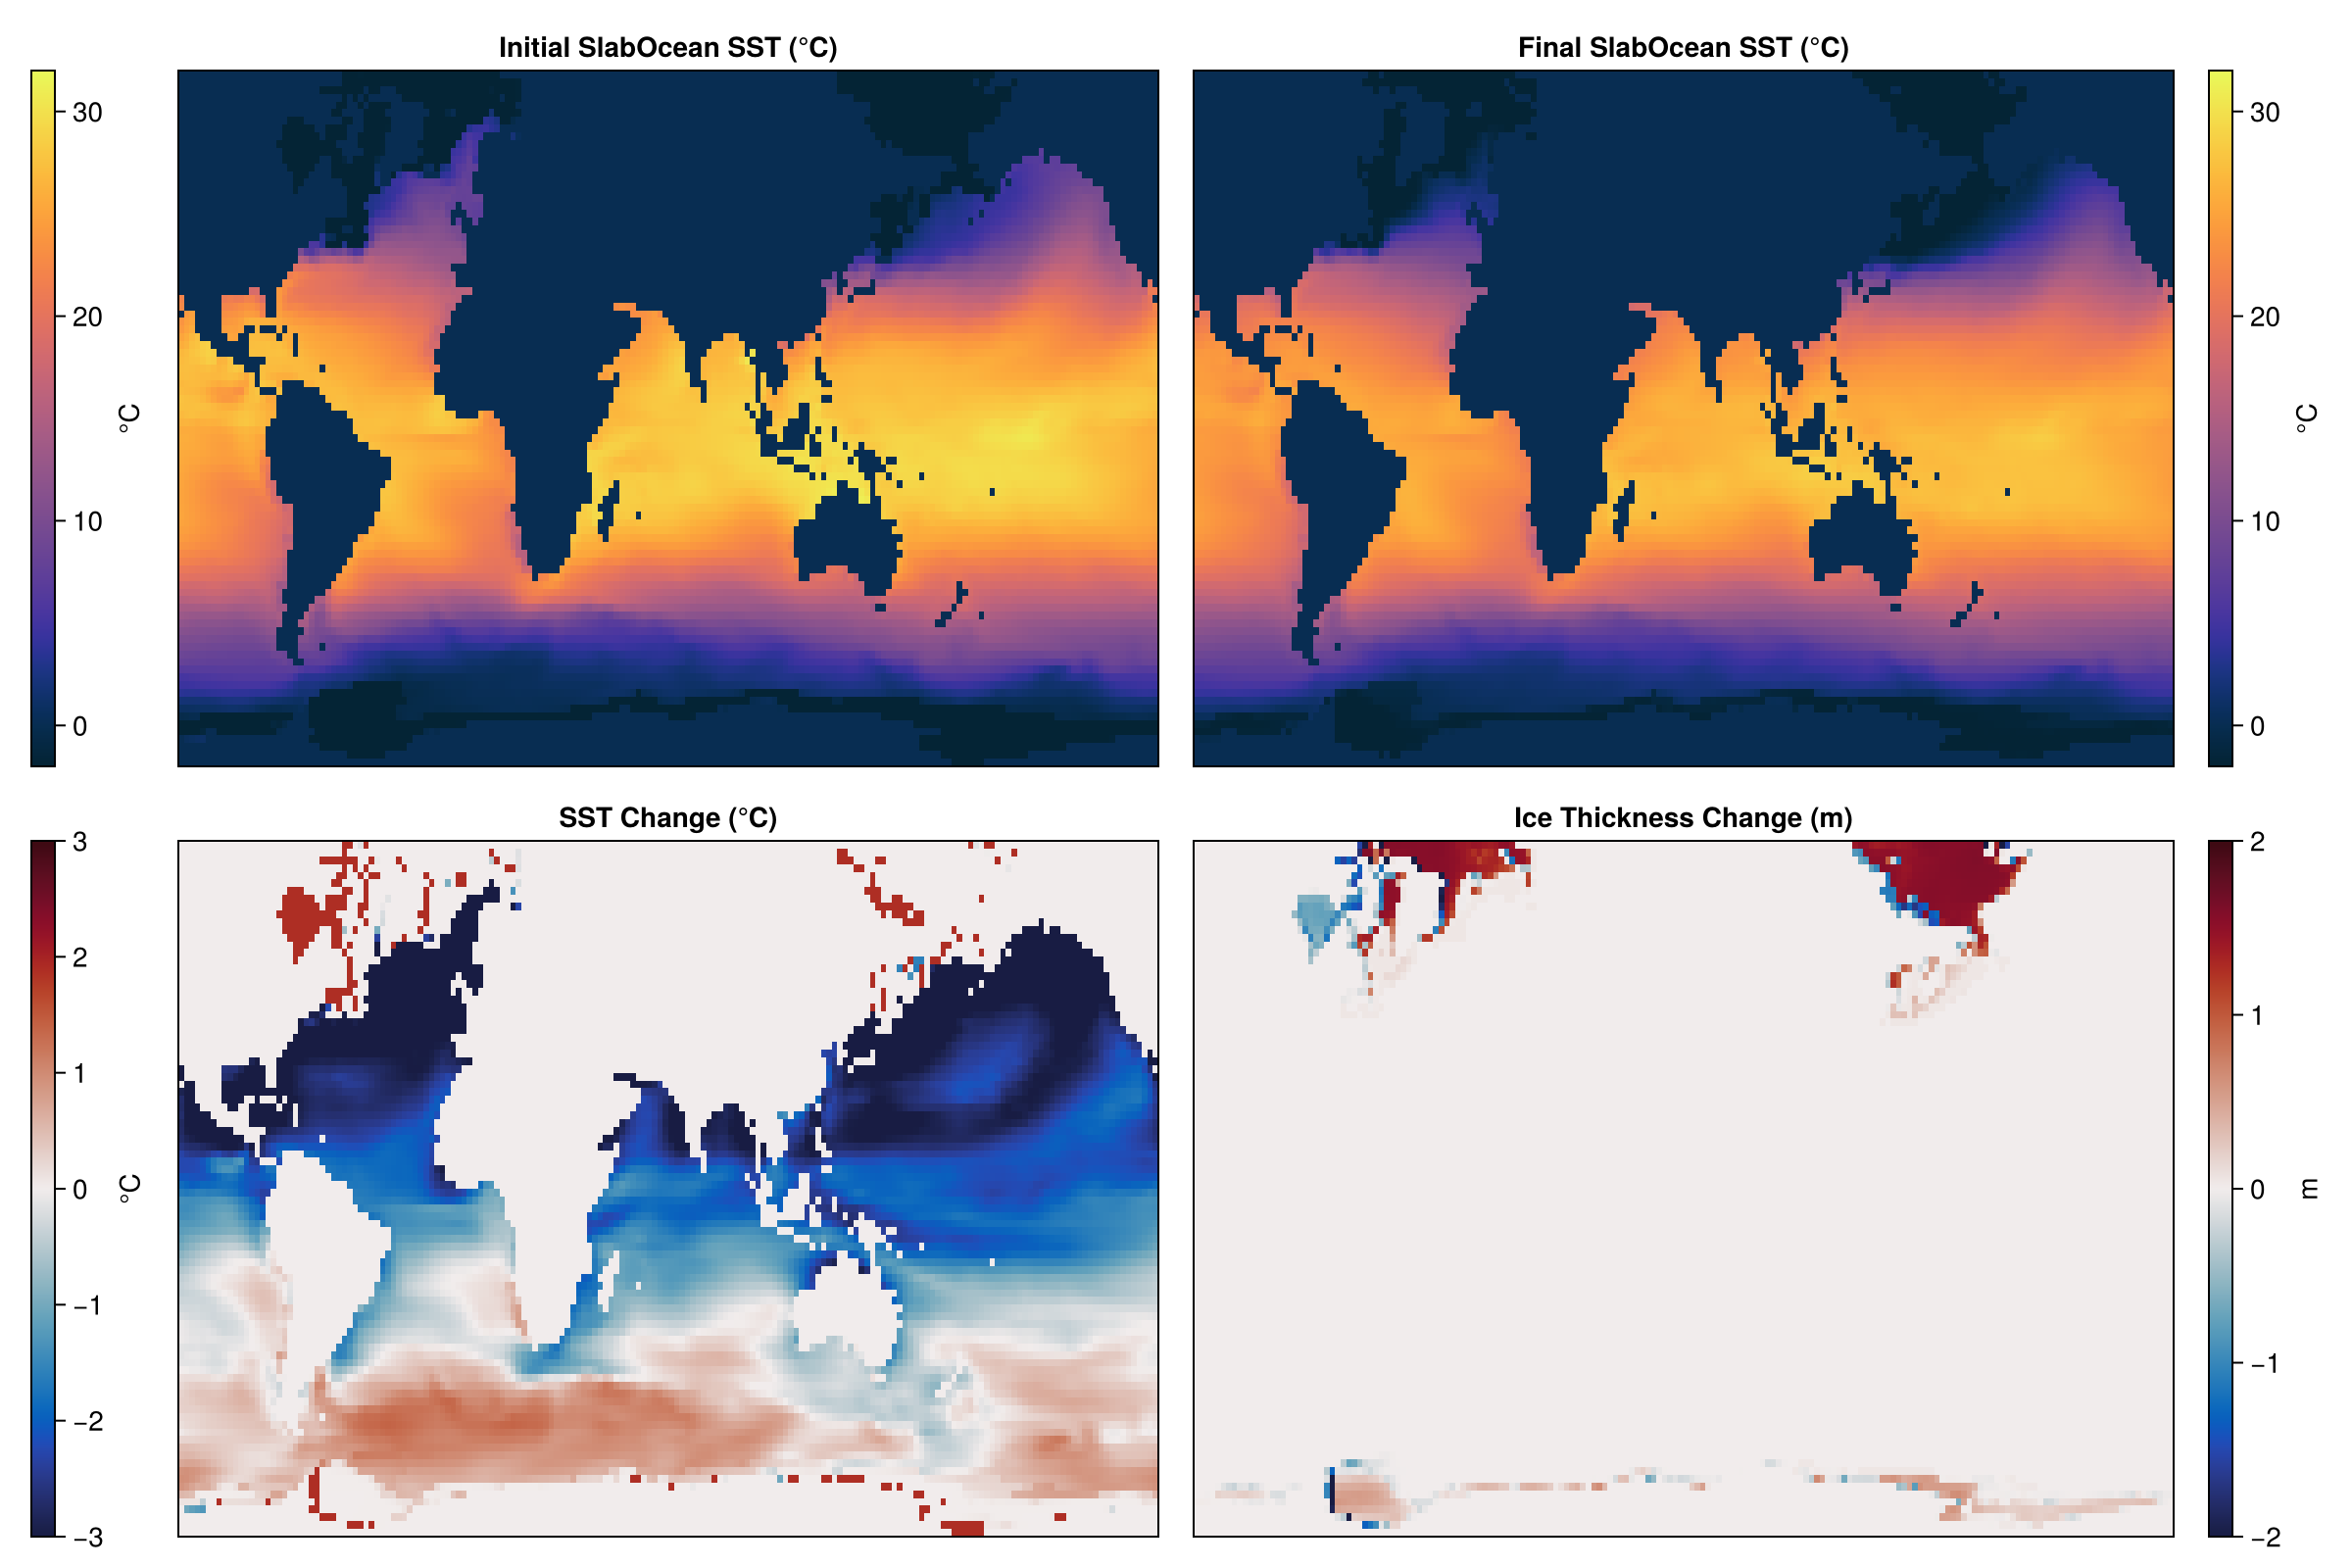

In [11]:
# Load saved output using FieldTimeSeries
SST_ts = FieldTimeSeries("slab_ocean_output.jld2", "SST")
h_ts   = FieldTimeSeries("slab_ocean_output.jld2", "h")
times  = SST_ts.times

@info "Loaded $(length(times)) snapshots from t=$(prettytime(times[1])) to t=$(prettytime(times[end]))"

# Get initial and final states
SST_first = Array(interior(SST_ts[1], :, :, 1))
SST_last = Array(interior(SST_ts[end], :, :, 1))
h_first = Array(interior(h_ts[1], :, :, 1))
h_last = Array(interior(h_ts[end], :, :, 1))

fig = Figure(size=(1200, 800), fontsize=14)

ax1 = Axis(fig[1, 1], title="Initial SlabOcean SST (°C)")
ax2 = Axis(fig[1, 2], title="Final SlabOcean SST (°C)")
ax3 = Axis(fig[2, 1], title="SST Change (°C)")
ax4 = Axis(fig[2, 2], title="Ice Thickness Change (m)")

hm1 = heatmap!(ax1, SST_first; colormap=:thermal, colorrange=(-2, 32), nan_color=:lightgray)
hm2 = heatmap!(ax2, SST_last; colormap=:thermal, colorrange=(-2, 32), nan_color=:lightgray)
hm3 = heatmap!(ax3, SST_last .- SST_first; colormap=:balance, colorrange=(-3, 3), nan_color=:lightgray)
hm4 = heatmap!(ax4, h_last .- h_first; colormap=:balance, colorrange=(-2, 2), nan_color=:lightgray)

Colorbar(fig[1, 0], hm1, label="°C")
Colorbar(fig[1, 3], hm2, label="°C")
Colorbar(fig[2, 0], hm3, label="°C")
Colorbar(fig[2, 3], hm4, label="m")

for ax in [ax1, ax2, ax3, ax4]
    hidedecorations!(ax)
end

fig


### Animated Evolution of SlabOcean SST, Sea Ice, and Atmospheric Temperature

The animation shows how the slab ocean, sea ice, and atmosphere evolve together. Our custom SlabOcean is fully integrated—it receives fluxes, evolves, and feeds back to other components just like any built-in ocean model.

In [ ]:
using NCDatasets

# Find the latest SpeedyWeather output directory
run_dirs = filter(x -> startswith(x, "run_") && isdir(x), readdir("."))
if isempty(run_dirs)
    error("No SpeedyWeather output directories found. Make sure output=true was set when creating the atmosphere.")
end
latest_run = sort(run_dirs)[end]
nc_file = joinpath(latest_run, "output.nc")

@info "Loading SpeedyWeather output from $nc_file"
SWO = Dataset(nc_file)

# Get temperature field dimensions
temp_data = SWO["temp"]
nlat, nlon, nlev, ntime = size(temp_data)

# Extract temperature at lowest level (surface) for all time steps
# SpeedyWeather saves time as last dimension, vertical level as third dimension
# We want the lowest level (index 1) at each time step
atmos_temp_timeseries = [reverse(temp_data[:, :, 1, t], dims=2) for t in 1:ntime]
simulation_times_days = [t / (24 * 3600) for t in times]  # Convert seconds to days

# SpeedyWeather time is typically in days since start
# We need to find matching time indices
# For now, let's use the first ntime frames that match our output
n_frames = min(length(times), length(atmos_temp_timeseries))

n = Observable(1)

# Create animation using FieldTimeSeries
fig = Figure(size=(1500, 400), fontsize=14)
title_text = @lift "t = $(prettytime(times[$n]))"
ax1 = Axis(fig[1, 1], title=@lift "SlabOcean SST at " * $title_text)
ax2 = Axis(fig[1, 2], title=@lift "Ice Thickness at " * $title_text)
ax3 = Axis(fig[1, 3], title=@lift "Atmospheric Temperature at " * $title_text)

hidedecorations!(ax1)
hidedecorations!(ax2)
hidedecorations!(ax3)

# Create observables for animation
SST_frame = @lift interior(SST_ts[$n], :, :, 1) .- interior(SST_ts[1], :, :, 1)
h_frame = @lift interior(h_ts[$n], :, :, 1)     .- interior(h_ts[1], :, :, 1)
atmos_temp_frame = @lift atmos_temp_timeseries[$n] .- atmos_temp_timeseries[2]

hm1 = heatmap!(ax1, SST_frame;        colormap=:bwr,     colorrange=(-2, 2),    nan_color=:lightgray)
hm2 = heatmap!(ax2, h_frame;          colormap=:ice,     colorrange=(-1, 1),    nan_color=:lightgray)
hm3 = heatmap!(ax3, atmos_temp_frame; colormap=:thermal, colorrange = (-5, 30), nan_color=:lightgray)

Colorbar(fig[1, 4], hm1, label="°C change")
Colorbar(fig[1, 5], hm2, label="m change")
Colorbar(fig[1, 6], hm3, label="°C change")

# Record animation
record(fig, "slab_ocean_evolution.mp4", 1:n_frames; framerate=2) do i
    n[] = i
end

close(SWO)

@info "Animation saved to slab_ocean_evolution.mp4"

[ Info: Loading SpeedyWeather output from run_0012/output.nc
[ Info: Animation saved to slab_ocean_evolution.mp4


In [13]:
using Base64
mp4_data = base64encode(read("slab_ocean_evolution.mp4"))
display("text/html", """<video controls autoplay loop><source src="data:video/mp4;base64,$mp4_data" type="video/mp4"></video>""")

<source src="data:video/mp4;base64,AAAAIGZ0eXBpc29tAAACAGlzb21pc28yYXZjMW1wNDEAAAAIZnJlZQARyLRtZGF0AAACrwYF//+r3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2NCByMzIwM00gNTJmNzY5NCAtIEguMjY0L01QRUctNCBBVkMgY29kZWMgLSBDb3B5bGVmdCAyMDAzLTIwMjQgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwgLSBvcHRpb25zOiBjYWJhYz0xIHJlZj01IGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMgbWU9aGV4IHN1Ym1lPTggcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5nZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTIgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEgZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xNSBsb29rYWhlYWRfdGhyZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVyYXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9hZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0zIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBrZXlpbnQ9MjUwIGtleWludF9taW49MiBzY2VuZWN1dD00MCBpbnRyYV9yZWZyZXNoPTAgcmNfbG9va2FoZWFkPTUwIHJjPWNyZiBtYnRyZWU9MSBjcmY9MjAuMCBxY29tcD0wLjYwIHFwbWluPTAgcXBtYXg9NjkgcXBzdGVwPTQgaXBfcmF0aW89MS40MCBhcT0xOjEuMDAAgAAA3b9liIQAFP/+99S3zLLtU2+2C6j3op4mX0N1JQGblsTtOoAAAAMAAAMAAAMAAAMAAAMAACrtg8NJfsa2aeEgAAADAAADAAADAAf6FJ/14z8KuIAMs+5ux1er8ekovREV0xZPvteczIFaA1EM79C2IXQZ4oav9pMClojWFCc43dmW0i8QpQqnEl0f1nHs/9EQAVoHH7JPalyUjBO3xFAnntj43rtGX5sGfLIMI/E4rv8sf6tR9rrntoIz5OiuinQj8gCuTpO8Gvp9FtrJZ1EGUgAOzh1HnOFgNayHcRa8KKUavd1UjwTeaUKv0e0+h/CGBIXZBC01RFkUEHECRg+kApNt6n85rzRnu/sn4BgJrZxkrDNu679x0Sxlv2Ws7eeaatoUKajshnUjwHgK3WMWe6RiNBmDH01vkbeGVlCNuYgFEclyso77T5832F/+0LN3qVCjX8F8NUGWECygFtpVNTFP4qoSwxXgDKU0ZxzFmtyUhV/B57m1aQe5fwtqFrZ69bfLPSDW17ulgWEkhik036ZsK5eEZjlq7V/p3XUSn0Yh6NeTCr9uU2hWg2/fRAYKAy7Js7JdnhK/T/q+ICnGgxmKYdEONYh066nHQCWwMsp7DlqLxGlwTaS3H37MhhfrEqOLi25U42yJnCw6oNML++L8aLUXM83qeOQpNf2CWlHiXR5C18Txk7vAu0eqYbgkfVMAvALGzdKjptr+UERqn4ZSeAIUKENXR/zEM5repJB/A3UyKh37mrN7gaPWTYd20QxMWfE06UbJfa8RoYCfERpAyUvi9frqOwltxOrLr7Aian0+AHNO3Mgk+EwjxfCDup4HzuXQktJiIqMGVpGvXQnb1SVkOkGMck7mN1cqkr2gYVTcqkx4XBT4JYfsPyZdPOH8jV85Uja/nK4Dlm0FsSUW0ha7NAI0CMw+Iz/unzLsV+RhxGoE28P3gOsNqyMh3xPhrPd7ZVAs1GByoHzAgnHGEcHxaA/wI2jlRDc79iPaY0S2WViwX+8rhw32hCsYh27/TipdfubxJ1f7eN3PTWl3vNnRxiJ4kPYCEOgcOtP+yMN36iNYakuQ4XQO23MKPsa8GHUN1304dXTva6R54YJyq3M8xkxeTGoHo6xt2HAsMSIu7Ft/rvRrwXU0DxLZ92rRMavQJYOqhSi0V6nd2q6uM+pXwgRjHiDAQL6fG9Pr7A1IOU3M0sFd7hWPllft8WAXEnFK1sAY1oWWLKmYDE1CHEda2dLQh0kyK2h7cueYoz2tM4qhFxXCbyK2Ktsco1yvUij5XzU6iJWCl3yiZox9LVT8TNzymMEASEr8gxYrTDc1rs23Wu4YtwMpayx3Zn1S4ktwU1ICgaajmk01bi7a5kIewPXcUc20B+IRH2q/Cjy3UiCWUJxFt2VZC9x1t2alCKEOrHCVvyVMnliQeo2Dhj+eEBIHu1qJkWfw3w2DwuJwFDvwoVRuFh4QwVu1EMtwUpEJ/qyZC/+cnUAN3ojE4Wrl9I/uOD8OicqzsyFUPzPwG/Gj//4GJWUChjtvpdXmWxIgmIcR7mqiuv3M5xTfVgHvPnNXZFcX42fDdCU8Ej/5Fwlrrnafkjk7i4FPY6P+sE4pMyOiCf+EH4qUVoK/smJ5zETlqarA4BcVyT8JFEfytNXxUeLXinlZofwv7fildEpjTh26u+4MvZ27RLU7RIaJ9Jtt+f7zvLd1rop/VwXSm6gWmbSqhO/Lxz+PZqu1aBQYE29jiAqtWc8T+44mtEWwu0dOKR3xDlIh5UluPukFPRLRemKv/h6fFdMU9spKUodZo4NukMdadueiWSOzgWeMdYMJtj4lfFmGVQC0J9M+bRTQlVs7+4EBHwb59xO83wfSv4aHVHQGMc6A2xI9xaBDminUX7O81/3sxQlR+JHvDJbkNozStPX78xeSKNKX8pZxab1v4Ej+vEnuKURGyDX3EgRloT+WkZN0yqZbKfrQv5PRxe5S3umb/+Wp6EACsSEUk20eJK4oiT0kPHX2dA/U8eO5xavTZ0YNw4sFHHRY+YpWFGxxs6QBPNRq4HQkf01jTnwslxDnYW+79bkfxRjDkK/aj0wgtLqo3R3QCYKYn7B1CKlGPajrvO4EXAo6MuGnEKWFHeMhhb6Pn8ZgZYt9j5Tw9WDGvaGhTKAehbLuUA9uX82EkReOSgg6UnFZx/riWyS4Y9hSstVlrFntzYdb9fmhdK8utVobQ8Gywx9N4FhyM+mJ6tQ8tIbyFouDP5JHD+/1k1uSgXVjPjzJAY2a5Gj5RZnT8FDnqjrRkshBcaYFAZzViSTbBvzpXARO+/JqOwO8anArIHg1EVb3FtSNr8Aw0i/7KN59wX4IwUD6Evq9jJ8fu+1J29E3wQbK7S2/ImWKUHTUfqa0w6C62B+iryDmyKoXksKOWHdFVz6KB9ccqJuby8pLsSa75DaTO+h+NFBpZso8HLsDqV2DreNVkVd3VvkTLxC0xXV22fQtcBQcCfkWZHEl8VVRvemnMdh1N07pNPWbkr3qsQEPgo8GmY3PnPmvQ3dJ0EkJ79oPmmYwynVyhIUduDkwONUW8IuFQNDRRXAPVvcD2/jyGcxosVYvTMC8Fe5YAbxOtCjTyPPaHEv+3mq3sUEQi4wNVHq+1N4FyJZ9SbMxCtuXXQfKjcHrbEvGSWho1Eueh6D0EHo05NXX4vhoCMktCeJVk249mZlQTPl+JaMIi+mPz/s43AD+H+3G52R0zFXbHGKOS1sVjNvgPS5JZefWBeG+w1Iv9HVuyG33zLQJu//1NsHBZwCEaUdWomMNOyujEz8yGuvAvSTis8lXJ/T/rK2VJZ4zT+pzeBk9g87NECnJOhwWLtKUTP07431l2QLSikWMzVZlpKEFsxOSjVMHzz4DW9rhdLHZ/+za3Fzj7rOYDMiOP/zTtt/t/+sRUCirFnTBSfLapPLCnkuloerwMdy7y/d+JgQFCmKRj4xGmvnYHwOomhNl7

---

## Summary: The Component Interface Contract

To build a custom component for ClimaOcean, implement:

| Method | Purpose |
|--------|---------|
| `ComponentExchanger(component, grid)` | Define exposed state variables |
| `net_fluxes(component)` | Define flux storage fields |
| `time_step!(component, Δt)` | Advance the component in time |

For ocean-like components, also implement `reference_density`, `heat_capacity`, `ocean_temperature`, and `ocean_salinity`.

### What We Demonstrated

1. Built a SlabOcean from scratch with struct and interface methods
2. Coupled it with existing components (sea ice + SpeedyWeather atmosphere)
3. Ran a full Earth system simulation

**Key takeaway**: As long as you implement the interface, your component works with ClimaOcean's coupling framework.

---

## Next Steps

- Explore the [ClimaOcean examples](https://github.com/CliMA/ClimaOcean.jl/tree/main/examples)
- Try building your own components
- Join the [GitHub Discussions](https://github.com/CliMA/ClimaOcean.jl/discussions)